In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sqlite3 import Error
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import roc_curve
from wordcloud import WordCloud, STOPWORDS
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import sqlite3
import pickle


In [3]:
df = pd.read_csv('data/Billboard_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5760 entries, 0 to 5759
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              5760 non-null   object 
 1   title             5760 non-null   object 
 2   artist            5760 non-null   object 
 3   weeks             5760 non-null   int64  
 4   rank              5760 non-null   int64  
 5   change            5760 non-null   object 
 6   broad_genre       5760 non-null   object 
 7   energy            5760 non-null   float64
 8   liveness          5760 non-null   float64
 9   tempo             5760 non-null   float64
 10  speechiness       5760 non-null   float64
 11  acousticness      5760 non-null   float64
 12  instrumentalness  5760 non-null   float64
 13  time_signature    5760 non-null   object 
 14  danceability      5760 non-null   float64
 15  key               5760 non-null   float64
 16  duration_ms       5760 non-null   object 


In [4]:
df.head()

,date,title,artist,weeks,rank,change,broad_genre,energy,liveness,tempo,...,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics
0,12/31/17,...Ready For It?,taylor swift,17,61,-2,pop,0.776,0.1550,160.053,...,0.0609,0.000000,4,0.616,2.0,208187,-6.519,0.459,1.0,"Knew he was a killer, first time that I saw hi..."
1,12/31/17,1-800-273-8255,logic,35,34,0,rap,0.572,0.1920,100.015,...,0.5700,0.000000,4,0.629,5.0,250173,-7.733,0.386,0.0,I've been on the low\nI been taking my time\nI...
2,12/31/17,All I Want For Christmas Is You,mariah carey,24,13,-4,r&b,0.625,0.0708,150.277,...,0.1640,0.000000,4,0.335,7.0,241107,-7.462,0.346,1.0,I don't want a lot for Christmas\nThere is jus...
3,12/31/17,Attention,charlie puth,36,39,5,pop,0.626,0.0848,100.041,...,0.0969,0.000031,4,0.774,3.0,211475,-4.432,0.777,0.0,"You've been running 'round, running 'round, ru..."
4,12/31/17,Bad At Love,halsey,17,9,1,rock,0.736,0.0879,118.369,...,0.0600,0.000000,4,0.675,0.0,181279,-3.604,0.607,1.0,Got a boy back home in Michigan\nAnd it tastes...


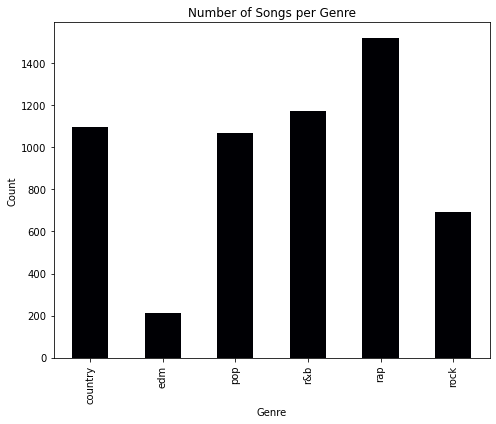

In [5]:
# Plotting genres to see labels

df.groupby('broad_genre').lyrics.count().plot.bar(ylim=0,figsize=(7,6),cmap = 'inferno')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Number of Songs per Genre')
plt.tight_layout()
#plt.savefig('genres_count.png')
plt.show()

In [6]:
## store the lyrics data
lyrics = df[df['broad_genre'] != 'edm']['lyrics']
print(lyrics[:10])

0    Knew he was a killer, first time that I saw hi...
1    I've been on the low\nI been taking my time\nI...
2    I don't want a lot for Christmas\nThere is jus...
3    You've been running 'round, running 'round, ru...
4    Got a boy back home in Michigan\nAnd it tastes...
5    I buy a new car for the bitch (for real)\nI te...
6    Bardi in a 'Rari, diamonds all over my body\n(...
7    First things first\nI'mma say all the words in...
8    Pop the trunk I open up I sold my soul for a g...
9    What's the problem? What's the problem?\nIn th...
Name: lyrics, dtype: object


In [7]:
#remove punctuation
lyrics = lyrics.str.replace(r'[^\w\d\s]',' ')
lyrics = lyrics.str.replace(r'\s+',' ')
lyrics = lyrics.str.replace(r'^\s+|\s+?$','')
lyrics

0       Knew he was a killer first time that I saw him...
1       I ve been on the low I been taking my time I f...
2       I don t want a lot for Christmas There is just...
3       You ve been running round running round runnin...
4       Got a boy back home in Michigan And it tastes ...
                              ...                        
5755    The greatest romance that s ever been sold So ...
5756    The snow is fallin The city is white You re ey...
5757    Deck the halls Deck the halls With boughs of h...
5758    Yo yo My flows remarkable Doc walk like Kane f...
5759    Chestnuts roasting on an open fire Jack Frost ...
Name: lyrics, Length: 5549, dtype: object

In [8]:
#change words to lower case

lyrics = lyrics.str.lower()
lyrics

0       knew he was a killer first time that i saw him...
1       i ve been on the low i been taking my time i f...
2       i don t want a lot for christmas there is just...
3       you ve been running round running round runnin...
4       got a boy back home in michigan and it tastes ...
                              ...                        
5755    the greatest romance that s ever been sold so ...
5756    the snow is fallin the city is white you re ey...
5757    deck the halls deck the halls with boughs of h...
5758    yo yo my flows remarkable doc walk like kane f...
5759    chestnuts roasting on an open fire jack frost ...
Name: lyrics, Length: 5549, dtype: object

In [9]:
#remove stop words from text messages

stop_words = set(stopwords.words('english'))

lyrics = lyrics.apply(lambda x: " ".join(term for term in x.split() if term not in stop_words))

In [10]:
#remove word stems using a Lemmatizer

lm = nltk.stem.WordNetLemmatizer()

lyrics = lyrics.apply(lambda x: ' '.join(lm.lemmatize(term) for term in x.split()))

In [11]:
#creating a bag-of-words

all_words = []

for word in lyrics:
    words = word_tokenize(word)
    for w in words:
        all_words.append(w)
        
all_words = nltk.FreqDist(all_words)

In [12]:
#print the total number words and the 15 most common words
print('Number of words : {}'.format(len(all_words)))
print('Most common words : {}'.format(all_words.most_common(20)))

Number of words : 30144
Most common words : [('like', 19659), ('got', 16984), ('know', 16887), ('na', 15791), ('oh', 15164), ('love', 13885), ('get', 13245), ('yeah', 12838), ('go', 10621), ('baby', 10165), ('girl', 9344), ('let', 9075), ('wan', 7849), ('cause', 7842), ('make', 7797), ('one', 7773), ('gon', 7367), ('see', 7189), ('back', 7115), ('want', 6940)]


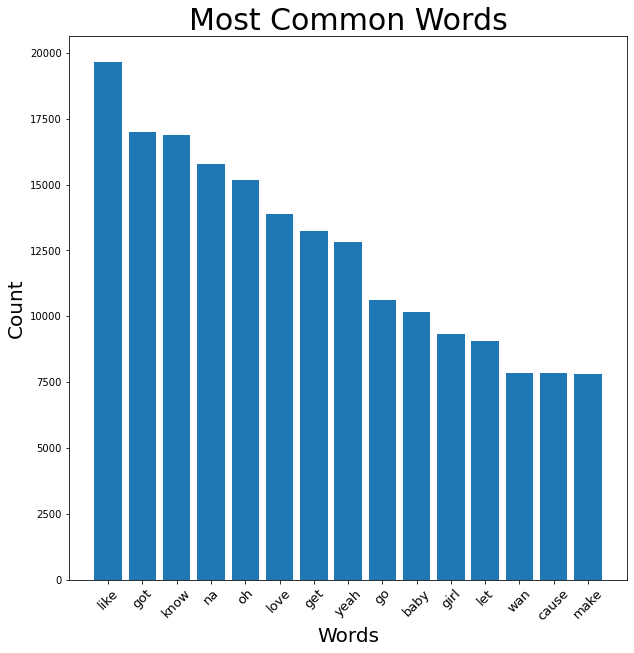

In [13]:
common = all_words.most_common(15)
common_10 = list(zip(*common))

fig, ax = plt.subplots(figsize = (10,10))
ax.bar(common_10[0],common_10[1])
ax.set_xlabel('Words', size=20)
ax.set_ylabel('Count',size=20)
ax.set_title('Most Common Words',size=30)
plt.xticks(size = 13, rotation=45)
#plt.savefig('most_common.png')
plt.show()

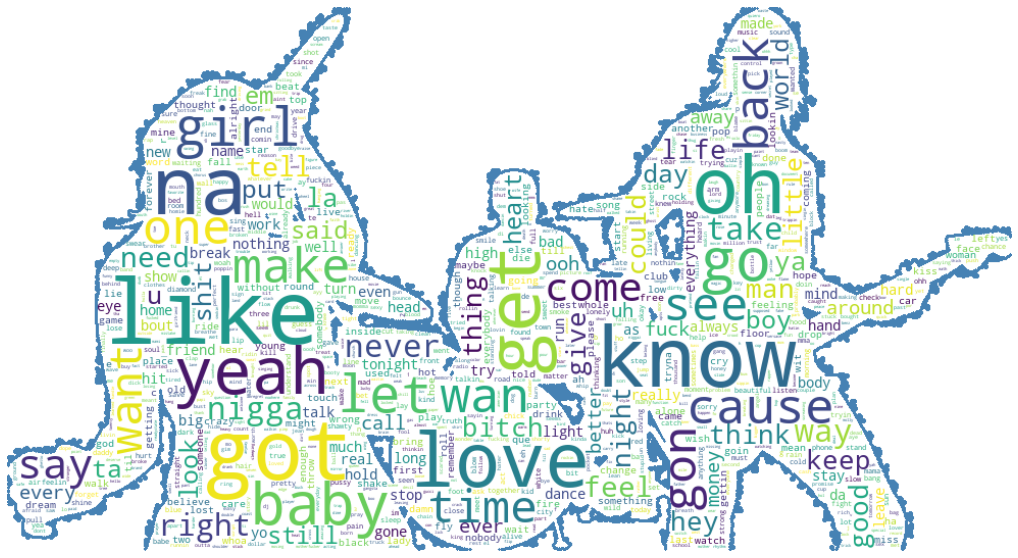

<Figure size 432x288 with 0 Axes>

In [14]:
man_mask = np.array(Image.open("images/band3.jpg"))
wc = WordCloud(background_color="white", max_words=2000, mask=man_mask,
               stopwords=stopwords, contour_width=3, contour_color='steelblue').generate_from_frequencies(dict(all_words))

# generate word cloud
wc.generate_from_frequencies(dict(all_words))
# store to file
#wc.to_file("band_wc.png")

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
#plt.imshow(solkey_mask, cmap=plt.cm.gray, interpolation='bilinear')
#plt.axis("off")
plt.show()

### MODELS

In [15]:
# Used lemmatizeter
wordnet = WordNetLemmatizer()
words = stopwords.words("english")
# Adding a cleaned column
df['cleaned'] = df['lyrics'].apply(lambda x: " ".join([wordnet.lemmatize(i) for i in re.sub("[^a-zA-Z^\n\d+\s^\s+|\s+?$]", " ", x).split() if i not in words]).lower())

In [16]:
#Tfidf Vectorizer
vectorizer = TfidfVectorizer(min_df= 2, stop_words="english", sublinear_tf=True, norm='l2',ngram_range=(1, 2))
final_features = vectorizer.fit_transform(df['cleaned'])
final_features_arr = final_features.toarray()
final_features.shape

(5760, 88930)

In [17]:
df.head()
df['cleaned']

0       knew killer first time i saw wondered many gir...
1       i low i taking time i feel like i mind it feel...
2       i want lot christmas there one thing i need i ...
3       you running round running round running round ...
4       got boy back home michigan and taste like jack...
                              ...                        
5755    the greatest romance ever sold so whadda ya kn...
5756    the snow fallin the city white you eye shinin ...
5757    deck hall deck hall with bough holly with boug...
5758    yo yo my flow remarkable doc walk like kane ku...
5759    chestnuts roasting open fire jack frost nippin...
Name: cleaned, Length: 5760, dtype: object

              precision    recall  f1-score   support

     country       0.64      0.76      0.70       223
         pop       0.38      0.54      0.45       206
         r&b       0.60      0.45      0.51       222
         rap       0.74      0.77      0.76       329
        rock       0.47      0.16      0.24       130

    accuracy                           0.59      1110
   macro avg       0.57      0.54      0.53      1110
weighted avg       0.59      0.59      0.58      1110

[[170  39   7   2   5]
 [ 37 112  28  22   7]
 [ 15  48  99  58   2]
 [ 15  25  25 254  10]
 [ 29  69   5   6  21]]


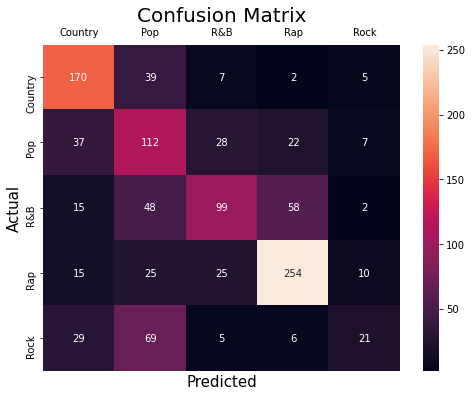

In [18]:
# #first we split our dataset into testing and training set:
# Because of imbalanced classes I remove edm. 
X = df[df['broad_genre']!='edm']['cleaned']
y = df[df['broad_genre']!='edm']['broad_genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
#instead of doing these steps one at a time, we can use a pipeline to complete them all at once
pipeline_rf = Pipeline([('vect', vectorizer),
                    ('chi2',  SelectKBest(chi2, k=12000)),
                    ('clf', RandomForestClassifier(n_estimators = 400,criterion='entropy'))])

model_rf = pipeline_rf.fit(X_train, y_train)
ytest = np.array(y_test)
#confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, model_rf.predict(X_test)))
print(confusion_matrix(ytest, model_rf.predict(X_test)))
categories=['Country','Pop','R&B','Rap','Rock']
fig, ax = plt.subplots(figsize=(8,6))    
sns.heatmap(confusion_matrix(ytest, model_rf.predict(X_test)), annot=True, fmt='g', xticklabels=categories, yticklabels=categories, ax=ax)
ax.set_title('Confusion Matrix', fontsize=20)
ax.set_xlabel('Predicted',fontsize=15)
ax.set_ylabel('Actual',fontsize=15)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)
#plt.savefig('base_heatmap.png')

### Creating a random forest model without Pipeline

In [19]:
vec = TfidfVectorizer()
vec_ft = vec.fit_transform(X_train)
vec_ft.shape

(4439, 27849)

In [20]:
vec_ft.todense

<bound method spmatrix.todense of <4439x27849 sparse matrix of type '<class 'numpy.float64'>'
	with 467145 stored elements in Compressed Sparse Row format>>

In [21]:
rf = RandomForestClassifier(n_estimators=300)

In [22]:
rf.fit(vec_ft,y_train)

RandomForestClassifier(n_estimators=300)

In [23]:
vec_ft_test = vec.transform(X_test)
vec_ft_test.shape

(1110, 27849)

In [25]:
rf.predict(vec_ft_test)[:100]

array(['country', 'rap', 'pop', 'rap', 'rap', 'pop', 'country', 'r&b',
       'r&b', 'country', 'country', 'pop', 'pop', 'rock', 'r&b', 'pop',
       'pop', 'pop', 'r&b', 'rap', 'pop', 'rap', 'pop', 'rap', 'country',
       'pop', 'rap', 'country', 'pop', 'country', 'r&b', 'pop', 'country',
       'pop', 'country', 'pop', 'r&b', 'r&b', 'country', 'rap', 'pop',
       'country', 'rap', 'rap', 'pop', 'country', 'rock', 'country',
       'r&b', 'pop', 'rap', 'rock', 'country', 'country', 'pop',
       'country', 'rap', 'pop', 'rap', 'pop', 'rock', 'pop', 'country',
       'rap', 'rap', 'rap', 'rap', 'country', 'country', 'rap', 'rap',
       'country', 'country', 'rap', 'rap', 'rap', 'r&b', 'pop', 'pop',
       'r&b', 'country', 'pop', 'rap', 'r&b', 'r&b', 'pop', 'country',
       'country', 'pop', 'pop', 'rap', 'pop', 'country', 'country', 'pop',
       'r&b', 'pop', 'rap', 'r&b', 'r&b'], dtype=object)

In [26]:
rf.score(vec_ft_test,y_test)

0.6072072072072072

In [27]:
## Feature importance 
feat_names = vec.get_feature_names() 
feat_names = np.array(feat_names)
len(feat_names), type(feat_names)
importance = rf.feature_importances_
importance
indices = np.argsort(importance)[-10:]
x = feat_names[np.argsort(importance)][-10:]
x

array(['love', 'like', 'got', 'little', 'girl', 'baby', 'fuck', 'bitch',
       'shit', 'nigga'], dtype='<U60')

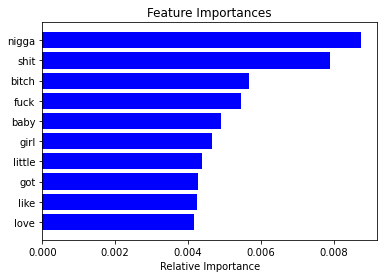

In [28]:
lst = ['love', 'like', 'got', 'little', 'girl', 'baby', 'fuck', 'bitch',
       'shit', 'nigga']

plt.title('Feature Importances')
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)),lst )
plt.xlabel('Relative Importance')
#plt.savefig('base_feature_imp.png')
plt.show()